In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.datasets import ImageFolder
import albumentations as A
import torchvision
# # Load CLIP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

/ext3/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = A.Compose(
        [
            A.Resize(224, 224, always_apply=True),
            A.Normalize(max_pixel_value=255.0, always_apply=True),
        ]
    )

In [4]:
# Set the path to your dataset folder
dataset_path = '/scratch/sg7729/DL_project/Evaluate/PokemonData'


# Define the dataset
dataset = torchvision.datasets.ImageFolder(root=dataset_path)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


In [13]:
print(len(test_dataset))
# test_dataset[0]

1364


In [14]:
import cv2
from segment_anything import build_sam, SamAutomaticMaskGenerator, sam_model_registry
from PIL import Image, ImageDraw
import clip
import torch
import numpy as np

In [ ]:
sam_checkpoint = "/scratch/sg7729/DL_project/SLIP/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

In [16]:
# Download the model weights to load them here
mask_generator = SamAutomaticMaskGenerator(
        model = sam,
        points_per_side = 16,
        pred_iou_thresh =  0.9,
        min_mask_region_area = 1,
        crop_overlap_ratio = 0.8 )

In [17]:
def convert_box_xywh_to_xyxy(box):
    x1 = box[0]
    y1 = box[1]
    x2 = box[0] + box[2]
    y2 = box[1] + box[3]
    return [x1, y1, x2, y2]

In [18]:
def segment_image(image, segmentation_mask):
    image_array = np.array(image)
    segmented_image_array = np.zeros_like(image_array)
    segmented_image_array[segmentation_mask] = image_array[segmentation_mask]
    segmented_image = Image.fromarray(segmented_image_array)
    black_image = Image.new("RGB", image.size, (0, 0, 0))
    transparency_mask = np.zeros_like(segmentation_mask, dtype=np.uint8)
    transparency_mask[segmentation_mask] = 255
    transparency_mask_image = Image.fromarray(transparency_mask, mode='L')
    black_image.paste(segmented_image, mask=transparency_mask_image)
    return black_image

In [19]:
def filter_annotations(annotations):
    annotations.sort(key=lambda x: x['area'], reverse=True)
    to_remove = set()
    for i in range(0, len(annotations)):
        a = annotations[i]
        for j in range(i + 1, len(annotations)):
            b = annotations[j]
            if i != j and j not in to_remove:
                # check if 
                if b['area'] < a['area']:
                    if (a['segmentation'] & b['segmentation']).sum() / b['segmentation'].sum() > 0.8:
                        # print('area')
                        to_remove.add(j)
#                         print(i, j)
#     print(to_remove)
    return [a for i, a in enumerate(annotations) if i not in to_remove]

In [20]:
class config:
    image_path = "/scratch/sg7729/DL_project/SLIP/Images"
    captions_path = "/scratch/sg7729/DL_project/SLIP/"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    text_tokenizer = "distilbert-base-uncased"

In [21]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names 
        """

        self.image_filenames = image_filenames # one description per image
        self.captions = list(captions) # one description per image
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=200
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

#         image = cv2.imread(f"{config.image_path}/{self.image_filenames[idx]}")
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image = self.transforms(image=image)['image']
        item['image'] = [1]
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)

In [22]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name='resnet50', pretrained=True, trainable=True
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

In [23]:
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{config.captions_path}/captions.csv")
    max_id = dataframe["id"].max() + 1
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode):
    transforms = A.Compose(
        [
            A.Resize(224, 224, always_apply=True),
            A.Normalize(max_pixel_value=255.0, always_apply=True),
        ]
    )
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=32,
        num_workers=2,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [24]:
# dataframe, _ = make_train_valid_dfs()
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_df, valid_df = make_train_valid_dfs()
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_loader = build_loaders(train_df, tokenizer, mode="train")
valid_loader = build_loaders(valid_df, tokenizer, mode="valid")


In [25]:
class TextEncoder(nn.Module):
    def __init__(self, model_name="distilbert-base-uncased", pretrained=True, trainable=True):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())
            
        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

In [26]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=128,
        dropout=0
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

In [27]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=1,
        image_embedding=2048,
        text_embedding=768,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        batch_size = len(image_embeddings) 
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [28]:
def get_masks_embeddings(model, masks): 
    model.eval()
    # Apply transforms
    transforms = A.Compose(
        [
            A.Resize(224, 224, always_apply=True),
            A.Normalize(max_pixel_value=255.0, always_apply=True),
        ],
    )

    
    processed_masks = []
    
    for mask in masks:
#         print(mask)
        mask = np.array(mask)
#         print(mask.shape)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = transforms(image=mask)['image']
        mask = np.transpose(mask, (2, 0, 1))
#         print(mask.shape)
        processed_masks.append(mask)
        
    processed_masks = torch.tensor(processed_masks)
    print(processed_masks.shape)

    mask_image_embeddings = []
    with torch.no_grad():
        image_features = model.image_encoder(processed_masks.to(device))
        image_embeddings = model.image_projection(image_features)
        mask_image_embeddings.append(image_embeddings)
    return torch.cat(mask_image_embeddings)

In [29]:
def find_matching_masks(model, image_embeddings, query, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained(config.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(config.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)
    
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), 1)
    print(dot_similarity)
    return dot_similarity, values

In [30]:
model = CLIPModel().to(device)
model.load_state_dict(torch.load('/scratch/sg7729/DL_project/SLIP/TrainL_Metric: 0.3710_ValidL_Metric: 0.7791_Epoch_99.pt'))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [31]:
def get_text_embeddings(model, valid_loader, tokenizer):
  
    model.eval()

    valid_text_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            encoded = tokenizer(batch['caption'])
            text_features = model.text_encoder(
                      input_ids=batch["input_ids"].to(config.device), attention_mask=batch["attention_mask"].to(config.device)
            )
            text_embeddings = model.text_projection(text_features)
            valid_text_embeddings.append(text_embeddings)
  
    return torch.cat(valid_text_embeddings)

In [32]:
# def find_matching_text(model, text_embeddings, query, captions, n=9):
#     with torch.no_grad():
#         query = torch.unsqueeze(query, 0)
#         image_features = model.image_encoder(query.to(config.device))
#         image_embeddings = model.image_projection(image_features)

#         image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
#         text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
#         dot_similarity = image_embeddings_n @ text_embeddings_n.T
#         values, indices = torch.topk(dot_similarity, n * 5)
#         print(values)
#         print(torch.argmax(values))
#         print(captions[torch.argmax(values)])

def find_matching_text(model, text_embeddings, query, captions, n=1):
    with torch.no_grad():
        query = torch.unsqueeze(query, 0)
        image_features = model.image_encoder(query.to(config.device))
        image_embeddings = model.image_projection(image_features)

        image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
        text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
        dot_similarity = image_embeddings_n @ text_embeddings_n.T
        values, indices = torch.topk(dot_similarity, n * 5)

        matches = [captions[idx] for idx in indices.cpu()[::5]][0]

    return matches[0]


In [33]:
text_embeddings = get_text_embeddings(model, valid_loader, tokenizer)

100%|██████████| 67/67 [00:04<00:00, 14.16it/s]


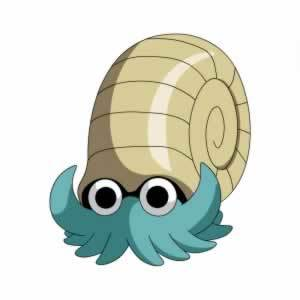

In [34]:
img, lable = test_dataset[25]
img

In [25]:
img = np.array(img) 
masks = mask_generator.generate(img)
print(len(masks))
new_annotaions = filter_annotations(masks)
print(len(new_annotaions))

61
43


In [ ]:
cropped_boxes = []
for mask in new_annotaions:
    cropped_boxes.append(segment_image(img, mask["segmentation"]).crop(convert_box_xywh_to_xyxy(mask["bbox"])))

In [ ]:
cropped_boxes[5]

In [103]:


# Loop through the test dataest and generate masks for each image
correct = 0
class_names = dataset.classes
for i in range(len(test_dataset)):
    img, label = test_dataset[i]
#     tensor_to_image = transforms.ToPILImage()(img)
    open_cv_image = np.array(img) 
    masks = mask_generator.generate(open_cv_image)
#     print('masks:', len(masks))
    annotations = masks
    new_annotaions = filter_annotations(annotations)
#     new_annotaions.pop(0)
#     print('new_annotaions:', len(new_annotaions))
    cropped_boxes = []
    for mask in new_annotaions:
        cropped_boxes.append(segment_image(img, mask["segmentation"]).crop(convert_box_xywh_to_xyxy(mask["bbox"])))
    processed_masks = []
    for mask in cropped_boxes:
    #         print(mask)
        mask = np.array(mask)
    #         print(mask.shape)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = transform(image=mask)['image']
        mask = np.transpose(mask, (2, 0, 1))
    #         print(mask.shape)
        processed_masks.append(mask)
    processed_masks = torch.tensor(processed_masks)

    for m in processed_masks:
        text_predicted = find_matching_text(model, text_embeddings, query=m, captions=valid_df['caption'].values)
#         print('label:', class_names[label], '    Predicted:', text_predicted)
        if class_names[label].lower() in text_predicted.lower():
            correct += 1
            break

    if i % 50 == 0:
        print(f"Accuracy after {i + 1} images: {correct / (i + 1)}")
    print(i)
    

print(f"Final accuracy: {correct / len(test_dataset)}")



{1, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 26, 28, 29}
Accuracy after 1 images: 1.0
0
{3, 6, 7, 10, 11, 12, 15, 18, 19, 20, 23, 24, 25, 26, 27}
1
{2, 3, 4, 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35}
2
{3, 7, 8, 15, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36}
3
{5, 13, 15, 19, 20, 23, 24, 25, 28, 29, 30, 31, 33, 34, 35, 37, 38, 39, 41}
4
{2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}
5
{6, 8, 11, 19, 20, 21, 22, 23}
6
{3, 8, 15, 19, 21, 22, 25}
7
{1, 2, 3, 4, 6, 8, 10, 11, 12, 13, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 38}
8
{1, 4, 7, 8, 10}
9
{3, 4, 6, 7, 10, 12, 14, 16, 17, 19, 22, 23, 25, 26, 27, 31, 34, 37, 38, 39, 41, 42, 43, 47, 48, 54, 57, 58, 59, 61}
10
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}
11
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19

error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [43]:

# Evaluate CLIP

# Loop through the test dataest and generate masks for each image
correct = 0
wrong = []
class_names = dataset.classes
for i in range(len(dataset)):
    img, label = dataset[i]
#     tensor_to_image = transforms.ToPILImage()(img)
    open_cv_image = np.array(img) 
    transform = A.Compose(
        [
            A.Resize(224, 224, always_apply=True),
            A.Normalize(max_pixel_value=255.0, always_apply=True),
        ]
    ) 
    open_cv_image = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2RGB)
    open_cv_image = transform(image=open_cv_image)['image']
    open_cv_image = np.transpose(open_cv_image, (2, 0, 1))
    image_tensor = torch.tensor(open_cv_image)

    text_predicted = find_matching_text(model, text_embeddings, query=image_tensor, captions=valid_df['caption'].values)
#     print('label:', class_names[label], '    Predicted:', text_predicted)
    if class_names[label].lower() in text_predicted.lower():
        correct += 1
    
    else:
        wrong.append(img)

    if i % 50 == 0:
        print(f"Accuracy after {i + 1} images: {correct / (i + 1)}")
#     print(i)
    
    

print(f"Final accuracy: {correct / len(dataset)}")



Accuracy after 1 images: 0.0
Accuracy after 51 images: 0.4117647058823529
Accuracy after 101 images: 0.37623762376237624
Accuracy after 151 images: 0.33774834437086093
Accuracy after 201 images: 0.4228855721393035
Accuracy after 251 images: 0.3944223107569721
Accuracy after 301 images: 0.45514950166112955
Accuracy after 351 images: 0.5242165242165242
Accuracy after 401 images: 0.5835411471321695
Accuracy after 451 images: 0.623059866962306
Accuracy after 501 images: 0.6586826347305389
Accuracy after 551 images: 0.6551724137931034
Accuracy after 601 images: 0.627287853577371
Accuracy after 651 images: 0.6036866359447005
Accuracy after 701 images: 0.62339514978602
Accuracy after 751 images: 0.6364846870838882
Accuracy after 801 images: 0.6454431960049938
Accuracy after 851 images: 0.6474735605170387
Accuracy after 901 images: 0.6648168701442841
Accuracy after 951 images: 0.6803364879074658
Accuracy after 1001 images: 0.6543456543456544
Accuracy after 1051 images: 0.6517602283539486
Accur

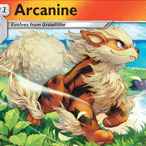

In [46]:
wrong[123]

## 

In [4]:
# https://www.kaggle.com/datasets/thedagger/pokemon-generation-one
import os
# !pip install kaggle --upgrade
os.environ['KAGGLE_USERNAME'] = 'saaketh1129'
os.environ['KAGGLE_KEY'] = '93e8ef765ac9c5800a4ce1017236aec0'

### For Flickr 8k



/bin/bash: kaggle: command not found


In [ ]:

!pip install kaggle --upgrade
!kaggle datasets download -d lantian773030/pokemonclassification

In [ ]:
!unzip pokemonclassification.zip